<a href="https://colab.research.google.com/github/nrajmalwar/END2.0/blob/main/Session_07/SST_Classification/SST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Check GPU

In [1]:
!nvidia-smi

Thu Jun 24 10:53:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import Libraries

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import spacy

import torch, torchtext
from torchtext.legacy import data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from google.colab import drive
drive.mount('/content/drive')

# Manual Seed
SEED = 43
torch.manual_seed(SEED)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Data Preprocessing

## Sentences

In [4]:
# Sentences contains index of the sentence and the text 
sentences_df = pd.read_csv('/content/drive/MyDrive/The School of AI/stanfordSentimentTreebank/datasetSentences.txt', sep = '\t', header = 0)
sentences_df.head()

,sentence_index,sentence
0,1,The Rock is destined to be the 21st Century 's...
1,2,The gorgeously elaborate continuation of `` Th...
2,3,Effective but too-tepid biopic
3,4,If you sometimes like to go to the movies to h...
4,5,"Emerges as something rare , an issue movie tha..."


In [5]:
print("Number of sentences = ", len(sentences_df))

Number of sentences =  11855


## Labels

In [6]:
# Labels contains phrase ids mapped to the sentiment values
labels_df = pd.read_csv('/content/drive/MyDrive/The School of AI/stanfordSentimentTreebank/sentiment_labels.txt', sep = '|', header = 0)
labels_df.head()

,phrase ids,sentiment values
0,0,0.50000
1,1,0.50000
2,2,0.44444
3,3,0.50000
4,4,0.42708


In [7]:
print("Number of indexes = ", len(labels_df))

Number of indexes =  239232


## Dictionary

In [8]:
# Dictionary maps the phrase texts to the phrase id
dict_df = pd.read_csv('/content/drive/MyDrive/The School of AI/stanfordSentimentTreebank/dictionary.txt', sep = '|', header = None)

# Rename the columns of dictionary
dict_df.rename(columns = {0: 'phrase', 1: 'phrase ids'}, inplace = True)
dict_df.head()

,phrase,phrase ids
0,!,0
1,! ',22935
2,! '',18235
3,! Alas,179257
4,! Brilliant,22936


In [9]:
print("Number of dictionary items = ", len(dict_df))

Number of dictionary items =  239232


## Target

In [10]:
target_df = pd.merge(labels_df, dict_df, how = 'left', on = 'phrase ids')
target_df.head()

,phrase ids,sentiment values,phrase
0,0,0.50000,!
1,1,0.50000,'
2,2,0.44444,' (
3,3,0.50000,' ( the cockettes
4,4,0.42708,' ( the cockettes )


## Common Sentences

In [11]:
common_sentences = pd.merge(sentences_df, target_df, how= 'inner', left_on='sentence', right_on='phrase')
common_sentences.drop(columns=["phrase"], inplace=True)
common_sentences.head()

,sentence_index,sentence,phrase ids,sentiment values
0,1,The Rock is destined to be the 21st Century 's...,226166,0.69444
1,2,The gorgeously elaborate continuation of `` Th...,226300,0.83333
2,3,Effective but too-tepid biopic,13995,0.51389
3,4,If you sometimes like to go to the movies to h...,14123,0.73611
4,5,"Emerges as something rare , an issue movie tha...",13999,0.86111


In [12]:
# Total number of sentences = 11855
# Total number of phrases = 239232
# Total number of common sentences (matching with phrases) = 11286
print("Number of common sentences = ", len(common_sentences))

Number of common sentences =  11286


In [13]:
common_sentences.to_csv("CommonSentences.csv", index=False, sep="|")

# Training and Test dataset
After applying above techiniques we get a combined DataFrame that has the following fields:

*   sentence_index : Original sentence_index in the datasetSentences.txt
*   sentence: The actual sentence
*   Phrase_Id: The Phrase_Id used for mapping/retrieving sentiment score
*   Sentiment_Score: Actual Sentiment score for the sentence


In [14]:
df = common_sentences
df.shape

(11286, 4)

## **Range expansion**
The sentiment scores are floats between [0, 1] so we convert this to equivalent integers between 0 and 5 (i.e 5 different classes)

In [15]:
def quantize_predictions(score_val):
    if(score_val >=0 and score_val <=0.2):
        return 0
    if(score_val > 0.2 and score_val <=0.4):
        return 1
    if(score_val > 0.4 and score_val <=0.6):
        return 2
    if(score_val > 0.6 and score_val <=0.8):
        return 3
    if(score_val > 0.8 and score_val <=1):
        return 4

df["label"] = df.loc[:,"sentiment values"].apply(quantize_predictions)

In [16]:
# Make all integer values of type int
df["sentence_index"] = df["sentence_index"].astype('int')
df["phrase ids"] = df["phrase ids"].astype('int')
df["label"] = df["label"].astype('int')

In [17]:
df.head()

,sentence_index,sentence,phrase ids,sentiment values,label
0,1,The Rock is destined to be the 21st Century 's...,226166,0.69444,3
1,2,The gorgeously elaborate continuation of `` Th...,226300,0.83333,4
2,3,Effective but too-tepid biopic,13995,0.51389,2
3,4,If you sometimes like to go to the movies to h...,14123,0.73611,3
4,5,"Emerges as something rare , an issue movie tha...",13999,0.86111,4


## **Create Datasets**

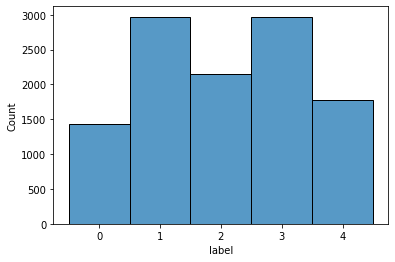

In [18]:
g = sns.histplot(df,
                x = "label",
                 discrete=True
                )

plt.show()

In [19]:
# Define Sentences and Label fields
Sentence = data.Field(sequential = True,
                      tokenize = 'spacy',
                      batch_first = True,
                      include_lengths = True)

Label = data.LabelField(tokenize ='spacy',
                        is_target = True,
                        batch_first = True,
                        sequential = False)

# fields variable
fields = [('sentence', Sentence),('label',Label)]

# Create example variable using torch library
example = [data.Example.fromlist([df.sentence.iloc[i], df.label.iloc[i]], fields) for i in range(df.shape[0])] 

# Compile all the training examples
stanTreeDataset = data.Dataset(example, fields)

## 70/30 train-test Split 

In [20]:
(train_set, valid_set) = stanTreeDataset.split(split_ratio=[0.70, 0.30],
                                      random_state=random.seed(SEED))

Sentence.build_vocab(train_set)
Label.build_vocab(train_set)

In [21]:
(len(train_set), len(valid_set))

(7900, 3386)

In [22]:
print('Size of input vocab : ', len(Sentence.vocab))
print('Size of label vocab : ', len(Label.vocab))
print('Top 10 words appreared repeatedly :', list(Sentence.vocab.freqs.most_common(10)))
print('Labels : ', Label.vocab.stoi)

Size of input vocab :  16406
Size of label vocab :  5
Top 10 words appreared repeatedly : [('.', 7452), (',', 6567), ('the', 5603), ('of', 4061), ('a', 4028), ('and', 4027), ('to', 2822), ('-', 2474), ('is', 2355), ("'s", 2289)]
Labels :  defaultdict(None, {1: 0, 3: 1, 2: 2, 4: 3, 0: 4})


## Create Iterator variables

In [23]:
train_iterator, valid_iterator = data.BucketIterator.splits((train_set, valid_set),
                                                          batch_size = 32, 
                                                          sort_key = lambda x: len(x.sentence),
                                                          sort_within_batch=True,
                                                          device = device)

In [24]:
next(iter(train_iterator))


[torchtext.legacy.data.batch.Batch of size 32]
	[.sentence]:('[torch.cuda.LongTensor of size 32x11 (GPU 0)]', '[torch.cuda.LongTensor of size 32 (GPU 0)]')
	[.label]:[torch.cuda.LongTensor of size 32 (GPU 0)]

In [25]:
import os, pickle
with open('tokenizer.pkl', 'wb') as tokens: 
    pickle.dump(Sentence.vocab.stoi, tokens)

# **Model Architecture**

In [26]:
class classifier(nn.Module):
    
    # Define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        
        super().__init__()          
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # LSTM layer
        self.encoder = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers,
                           bidirectional=True, 
                           dropout=dropout,
                           batch_first=True)
        
        # Dense layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text, text_lengths):
        
        # text = [batch size, sent_length]
        embedded = self.embedding(text)
        # embedded = [batch size, sent_len, emb dim]
      
        # packed sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True)
        
        packed_output, (hidden, cell) = self.encoder(packed_embedded)
        #hidden = [batch size, num layers * num directions,hid dim]
        #cell = [batch size, num layers * num directions,hid dim]
    
        # Hidden = [batch size, hid dim * num directions]
        dense_outputs = self.fc(hidden)   
        
        # Final activation function softmax
        output = F.softmax(dense_outputs[0], dim=1)
            
        return output

In [27]:
# Define hyperparameters
size_of_vocab = len(Sentence.vocab)
embedding_dim = 256
num_hidden_nodes = 128
num_output_nodes = len(df.label.unique())
num_layers = 2
dropout = 0.4

# Instantiate the model
model = classifier(size_of_vocab,
                   embedding_dim,
                   num_hidden_nodes,
                   num_output_nodes,
                   num_layers,
                   dropout = dropout)

In [28]:
print(model)

# No. of trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')

classifier(
  (embedding): Embedding(16406, 256)
  (encoder): LSTM(256, 128, num_layers=2, batch_first=True, dropout=0.4, bidirectional=True)
  (fc): Linear(in_features=128, out_features=5, bias=True)
)
The model has 4,991,109 trainable parameters


In [29]:
# define optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.CrossEntropyLoss()

# define metric
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    _, predictions = torch.max(preds, 1)
    
    correct = (predictions == y).float() 
    acc = correct.sum() / len(correct)
    return acc
    
# push to cuda if available
model = model.to(device)
criterion = criterion.to(device)

# **Training & Evaluation Functions**

In [30]:
def train(model, iterator, optimizer, criterion):
    
    # initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    # set the model in training phase
    model.train()  
    
    for batch in iterator:
        
        # resets the gradients after every batch
        optimizer.zero_grad()   
        
        # retrieve text and no. of words
        sentence, sentence_lengths = batch.sentence
        
        # convert to 1D tensor
        predictions = model(sentence, sentence_lengths).squeeze()  

        # compute the loss
        loss = criterion(predictions, batch.label)        
        
        # compute the binary accuracy
        acc = binary_accuracy(predictions, batch.label)   
        
        # backpropage the loss and compute the gradients
        loss.backward()       
        
        # update the weights
        optimizer.step()      
        
        # loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [31]:
def evaluate(model, iterator, criterion):
    
    # initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    # deactivating dropout layers
    model.eval()
    
    # deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
        
            # retrieve text and no. of words
            sentence, sentence_lengths = batch.sentence
            
            # convert to 1d tensor
            predictions = model(sentence, sentence_lengths).squeeze()
            
            # compute loss and accuracy
            loss = criterion(predictions, batch.label)
            acc = binary_accuracy(predictions, batch.label)
            
            # keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

# **Model Training**

In [36]:
N_EPOCHS = 30
best_valid_loss = float('inf')

train_losses = []
valid_losses = []
train_accuracy = []
valid_accuracy = []

for epoch in range(N_EPOCHS):
     
    # train the model
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)

    # evaluate the model
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    train_accuracy.append(train_acc)
    train_losses.append(train_loss)

    valid_accuracy.append(valid_acc)
    valid_losses.append(valid_loss)

    print(f'\tEpoch: {epoch} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% \n')

	Epoch: 0 | Train Loss: 1.329 | Train Acc: 58.71%
	 Val. Loss: 1.533 |  Val. Acc: 34.77% 

	Epoch: 1 | Train Loss: 1.301 | Train Acc: 62.45%
	 Val. Loss: 1.540 |  Val. Acc: 33.90% 

	Epoch: 2 | Train Loss: 1.277 | Train Acc: 64.87%
	 Val. Loss: 1.547 |  Val. Acc: 33.23% 

	Epoch: 3 | Train Loss: 1.249 | Train Acc: 67.80%
	 Val. Loss: 1.546 |  Val. Acc: 33.12% 

	Epoch: 4 | Train Loss: 1.226 | Train Acc: 70.24%
	 Val. Loss: 1.549 |  Val. Acc: 33.07% 

	Epoch: 5 | Train Loss: 1.207 | Train Acc: 71.62%
	 Val. Loss: 1.550 |  Val. Acc: 33.15% 

	Epoch: 6 | Train Loss: 1.190 | Train Acc: 72.89%
	 Val. Loss: 1.559 |  Val. Acc: 32.24% 

	Epoch: 7 | Train Loss: 1.178 | Train Acc: 74.09%
	 Val. Loss: 1.552 |  Val. Acc: 32.95% 

	Epoch: 8 | Train Loss: 1.163 | Train Acc: 75.35%
	 Val. Loss: 1.561 |  Val. Acc: 31.77% 

	Epoch: 9 | Train Loss: 1.156 | Train Acc: 75.77%
	 Val. Loss: 1.561 |  Val. Acc: 32.33% 

	Epoch: 10 | Train Loss: 1.145 | Train Acc: 76.64%
	 Val. Loss: 1.562 |  Val. Acc: 32.21% 

# Training Graphs

Text(0.5, 1.0, 'Loss')

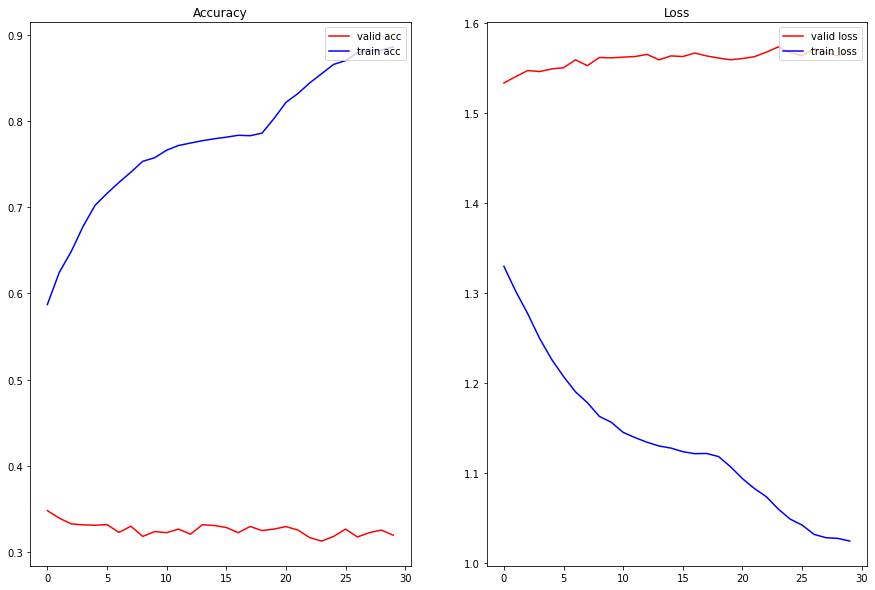

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(15,10))

axs[0].plot(valid_accuracy, '-r', label='valid acc')
axs[0].plot(train_accuracy, '-b', label='train acc')
axs[0].legend(loc = "upper right")
axs[0].set_title("Accuracy")

axs[1].plot(valid_losses, 'r', label='valid loss')
axs[1].plot(train_losses, 'b', label='train loss')
axs[1].legend(loc = "upper right")
axs[1].set_title("Loss")

# Print prediction of 10 samples from the test dataset

In [33]:
# load weights and tokenizer

path='./saved_weights.pt'
model.load_state_dict(torch.load(path));
model.eval();
tokenizer_file = open('./tokenizer.pkl', 'rb')
tokenizer = pickle.load(tokenizer_file)

# inference 

nlp = spacy.load('en')

def classify_sentence(sentence):
        
    # tokenize the sentence 
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)] 
    # convert to integer sequence using predefined tokenizer dictionary
    indexed = [tokenizer[t] for t in tokenized]        
    # compute no. of words        
    length = [len(indexed)]
    # convert to tensor                                    
    tensor = torch.LongTensor(indexed).to(device)   
    # reshape in form of batch, no. of words           
    tensor = tensor.unsqueeze(1).T  
    # convert to tensor                          
    length_tensor = torch.LongTensor(length)
    # Get the model prediction                  
    prediction = model(tensor, length_tensor)

    _, pred = torch.max(prediction, 1) 
    
    #return categories[pred.item()]
    return pred.item()

In [34]:
label_dict = {0 : 'very negative',
              1 : 'negative',
              2 : 'neutral',
              3 : 'positive',
              4 : 'very positive'}

# Print 10 samples from the test dataset

for i in range(10):
  print("Sentence : ", ' '.join(valid_set.examples[i].sentence))
  pred = classify_sentence(' '.join(valid_set.examples[i].sentence))
  print(f"Predicted : {label_dict[pred]}")
  print(f"Target : {label_dict[valid_set.examples[i].label]}\n")

Sentence :  But what is missing from it all is a moral .
Predicted : very negative
Target : negative

Sentence :  All leather pants & augmented boobs , Hawn is hilarious as she tries to resuscitate the fun - loving libertine lost somewhere inside the conservative , handbag - clutching Sarandon .
Predicted : negative
Target : positive

Sentence :  It kinda works and qualifies as cool at times , but is just too lame to work or be cool at others .
Predicted : very negative
Target : neutral

Sentence :  ` Stock up on silver bullets for director Neil Marshall 's intense freight train of a film . '
Predicted : negative
Target : positive

Sentence :  Frei assembles a fascinating profile of a deeply humanistic artist who , in spite of all that he 's witnessed , remains surprisingly idealistic , and retains an extraordinary faith in the ability of images to communicate the truth of the world around him .
Predicted : negative
Target : positive

Sentence :  You 'll just have your head in your han